<a href="https://colab.research.google.com/github/nath1424/TERCERA-ACTIVIDAD-DEEP-LEARNING/blob/main/deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TERCERA ACTIVIDAD: DEEP LEARNING

#INTEGRANTES

- Fabian Espinoza, Jaime              18120166
- Flores Mauricio, Daniel Santiago    20120084
- Pesantes Egúsquiza, Claudia Mirian  20120231
- Rodriguez Garcia, Alejandra Yohana  20120049
- Roque Aybar, Angel David            19120169
- Valencia Carhuas, Flavia Mercedes   19120190
- Valladares Bengolea, Nathaly Pelaya 19120184


# 1.lstm

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')


#Este código en Python importa los módulos sys y warnings y
#configura el sistema para ignorar todas las advertencias emitidas por el módulo warnings.
#Esto significa que cualquier advertencia generada en el código posterior no se mostrará
#en la salida estándar.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

#Este código importa bibliotecas y configura entornos para tareas de aprendizaje automático y
#procesamiento de datos con TensorFlow, NumPy, Matplotlib, Seaborn, Pandas y scikit-learn.
#También se establece una semilla aleatoria para la reproducibilidad.



In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)


Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Asumiendo que 'df_comp' se ha cargado correctamente desde Google Drive como se muestra en el código anterior

# Crea una instancia de MinMaxScaler y ajusta los datos de la columna 'Close'
minmax = MinMaxScaler().fit(df_comp['Close'].values.reshape(-1, 1))

# Escala los datos de la columna 'Close'
df_log = minmax.transform(df_comp['Close'].values.reshape(-1, 1))

# Crea un nuevo DataFrame 'df_log' con los datos escalados
df_log = pd.DataFrame(df_log, columns=['Close'])

# Muestra las primeras filas del DataFrame df_log
print(df_log.head())



      Close
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893


Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 30

# Divide el DataFrame df_comp en conjuntos de entrenamiento y prueba
df_train, df_test = train_test_split(df_comp, test_size=test_size, shuffle=False)

# Verifica las formas de los conjuntos
print("Forma de df_comp:", df_comp.shape)
print("Forma de df_train:", df_train.shape)
print("Forma de df_test:", df_test.shape)


Forma de df_comp: (1745, 7)
Forma de df_train: (1715, 7)
Forma de df_test: (30, 7)


In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

    #En el código proporcionado:

#La clase Model define un modelo de red neuronal recurrente (RNN) con celdas LSTM para tareas de regresión.
#La función calculate_accuracy calcula la precisión de las predicciones en problemas de regresión.
#La función anchor aplica un filtro de media móvil ponderada a una señal de entrada.
#En conjunto, estos componentes son útiles en análisis de series temporales y aprendizaje automático.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

#En el contexto de un modelo de predicción de series temporales:

#num_layers: Número de capas en la red neuronal (1 capa en este caso).
#size_layer: Tamaño de las unidades en cada capa (128 unidades).
#timestamp: Longitud de las secuencias de tiempo utilizadas en el entrenamiento (5).
#epoch: Cantidad de veces que se recorre el conjunto de datos de entrenamiento durante el entrenamiento (300 veces).
#dropout_rate: Tasa de abandono aplicada durante el entrenamiento (20% de unidades se dejan caer).
#future_day: Número de días en el futuro que se desea predecir (igual al tamaño del conjunto de prueba).
#learning_rate: Tasa de aprendizaje que controla cuánto se ajustan los parámetros del modelo (0.01 en este caso).

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

#La función forecast realiza predicciones de series temporales utilizando un modelo de red neuronal recurrente (RNN) previamente entrenado. Aquí está un resumen de lo que hace:
#Configura el modelo RNN.
#Entrena el modelo en datos de series temporales.
#Realiza predicciones para un número especificado de días en el futuro.
#Transforma y suaviza las predicciones.
#Devuelve las predicciones finales.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
#Importando las bibliotecas

In [ ]:
class Model(tf.keras.Model):
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias=0.1,
    ):
        super(Model, self).__init__()
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple=False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple=False,
        )
        self.X = tf.keras.layers.Input(shape=(None, size))
        self.Y = tf.keras.layers.Input(shape=(output_size,))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob=forget_bias
        )
        self.hidden_layer = tf.keras.layers.Input(
            shape=(None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state=self.hidden_layer, dtype=tf.float32
        )
        self.logits = tf.keras.layers.Dense(output_size)(self.outputs[0])
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )



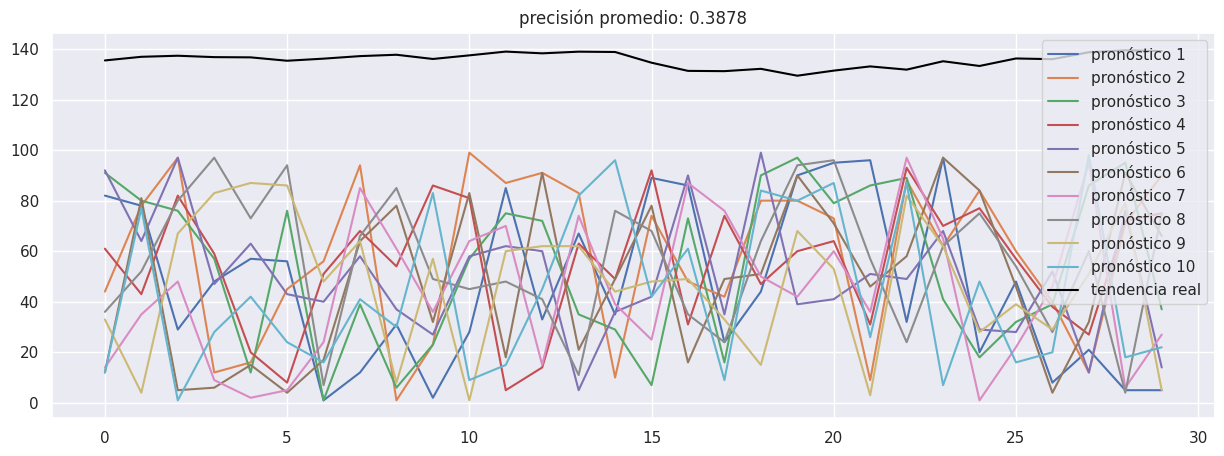

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()

# 2.bidirectional-lstm

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

#import sys: Importa el módulo sys, que proporciona acceso a algunas variables del sistema y funciones relacionadas con la interpretación de Python.
#import warnings: Importa el módulo warnings, que permite controlar y personalizar cómo se manejan las advertencias generadas por Python.
#if not sys.warnoptions:: Esta línea verifica si la lista sys.warnoptions está vacía, lo que significa que no se han configurado opciones de advertencia a través de la línea de comandos o el entorno. Si está vacía, el código continuará.
#warnings.simplefilter('ignore'): Configura el filtro de advertencias para que ignore todas las advertencias. Esto significa que las advertencias generadas por Python no se mostrarán en la salida estándar.


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

#Este código importa las bibliotecas necesarias y configura algunas opciones para trabajar con TensorFlow y datos de series temporales. En resumen:
#Importa las bibliotecas tensorflow (como tf), numpy, matplotlib.pyplot, seaborn, pandas y herramientas relacionadas.
#Establece una semilla aleatoria para TensorFlow para reproducibilidad.
#Configura el estilo de visualización con sns.set() utilizando el estilo predeterminado de Seaborn.
#Configura algunas opciones específicas de TensorFlow para establecer una semilla aleatoria.

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Asumiendo que 'df_comp' se ha cargado correctamente desde Google Drive como se muestra en el código anterior

# Crea una instancia de MinMaxScaler y ajusta los datos de la columna 'Close'
minmax = MinMaxScaler().fit(df_comp['Close'].values.reshape(-1, 1))

# Escala los datos de la columna 'Close'
df_log = minmax.transform(df_comp['Close'].values.reshape(-1, 1))

# Crea un nuevo DataFrame 'df_log' con los datos escalados
df_log = pd.DataFrame(df_log, columns=['Close'])

# Muestra las primeras filas del DataFrame df_log
print(df_log.head())


      Close
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893


Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df_log.shape, df_train.shape, df_test.shape

#test_size = 30: Aquí se define una variable test_size que se utiliza para indicar cuántas filas se deben tomar como datos de prueba en el DataFrame.
#simulation_size = 10: Esta línea establece una variable simulation_size que representa cuántas simulaciones se realizarán. Especifica cuántas veces se ejecutará un proceso similar.
#df_train = df_log.iloc[:-test_size]: Aquí, se crea un nuevo DataFrame llamado df_train. Utiliza el DataFrame df_log y selecciona todas las filas excepto las últimas 30, lo que significa que df_train contendrá las filas utilizadas como datos de entrenamiento.
#df_test = df_log.iloc[-test_size:]: Esta línea crea otro DataFrame llamado df_test. Toma las últimas 30 filas del DataFrame df_log y las almacena en df_test, que se utilizarán como datos de prueba.
#df_log.shape, df_train.shape, df_test.shape: Esta línea muestra las formas (número de filas y columnas) de los DataFrames df_log, df_train y df_test. Proporciona información sobre la estructura de estos conjuntos de datos.



((1745, 1), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

#Este código define una clase llamada Model que construye un modelo de red neuronal recurrente bidireccional utilizando TensorFlow.
#El modelo toma datos de entrada (self.X) y produce predicciones (self.logits).
#El objetivo principal es predecir las etiquetas de salida (self.Y) minimizando la función de costo (self.cost) con un optimizador.
#El código también incluye funciones auxiliares para calcular la precisión y suavizar señales.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

#Claro, aquí tienes un resumen más conciso:

#- `num_layers`: Número de capas en la red neuronal (1 capa en este caso).
#- `size_layer`: Tamaño de las capas en la red (128 unidades).
#- `timestamp`: Tamaño de las secuencias temporales (5 pasos de tiempo).
#- `epoch`: Número de iteraciones de entrenamiento (300 épocas).
#- `dropout_rate`: Tasa de dropout para la regularización (80%).
#- `future_day`: Días a predecir en el futuro (30 días).
#- `learning_rate`: Tasa de aprendizaje del modelo (0.01).

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]
#Por supuesto, aquí tienes una breve descripción de cada parte del código:
#1. **Inicialización del modelo y la sesión**: Configura el modelo y la sesión de TensorFlow. (Código de inicialización)
#2. **Bucle de entrenamiento**: Entrena el modelo para predecir la serie de tiempo. (Código de entrenamiento)
#3. **Predicción en el conjunto de entrenamiento**: Realiza predicciones en el conjunto de entrenamiento. (Código de predicción en entrenamiento)
#4. **Predicción en el conjunto de prueba**: Realiza predicciones en el conjunto de prueba. (Código de predicción en prueba)
#5. **Ajuste de las fechas de predicción**: Ajusta las fechas de las predicciones. (Código de ajuste de fechas)
#6. **Transformación inversa**: Escala las predicciones nuevamente al rango original. (Código de inversión de escala)
#7. **Suavizado de las predicciones**: Suaviza las predicciones para obtener una salida más limpia. (Código de suavizado)
#8. **Retorno de las predicciones**: Devuelve las predicciones suavizadas para el conjunto de prueba. (Código de retorno de predicciones)


In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)

Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[43, 34, 72, 31, 77], [31, 7, 75, 80, 1], [58, 32, 42, 94, 51], [48, 26, 39, 29, 55], [82, 28, 36, 63, 67], [3, 13, 67, 64, 20], [61, 46, 87, 21, 95], [40, 33, 42, 49, 85], [47, 66, 63, 21, 17], [49, 35, 21, 79, 99]]


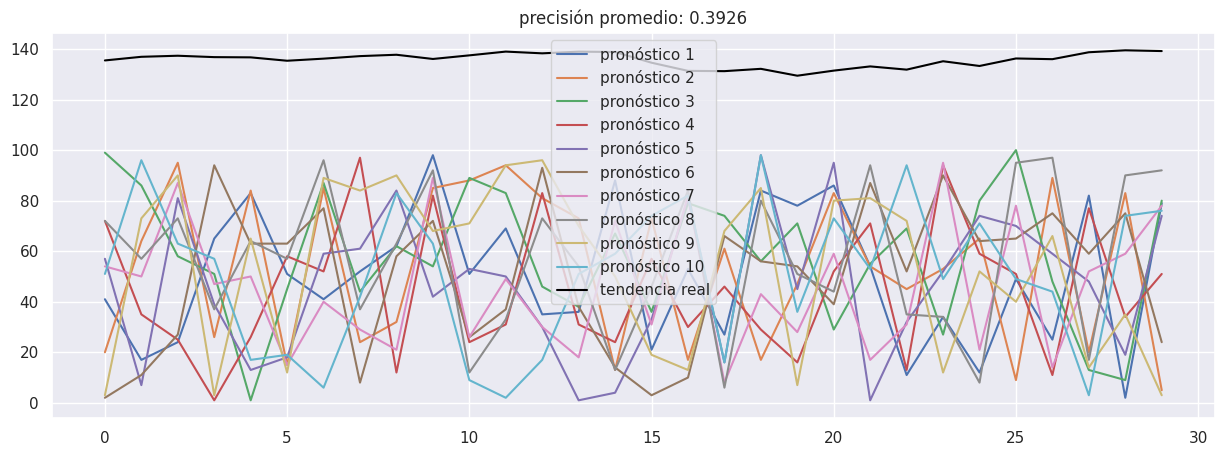

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()


# 3.lstm-2path

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

##import sys: Importa el módulo sys, que proporciona acceso a algunas variables del sistema y funciones relacionadas con la interpretación de Python.
#import warnings: Importa el módulo warnings, que permite controlar y personalizar cómo se manejan las advertencias generadas por Python.
#if not sys.warnoptions:: Esta línea verifica si la lista sys.warnoptions está vacía, lo que significa que no se han configurado opciones de advertencia a través de la línea de comandos o el entorno. Si está vacía, el código continuará.
#warnings.simplefilter('ignore'): Configura el filtro de advertencias para que ignore todas las advertencias. Esto significa que las advertencias generadas por Python no se mostrarán en la salida estándar.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

#Este código realiza las siguientes acciones:
#Importa bibliotecas clave, como TensorFlow, NumPy, Matplotlib, Seaborn, Pandas y scikit-learn.
#Configura el estilo de las visualizaciones usando Seaborn.
#Establece una semilla para la generación de números aleatorios en TensorFlow para reproducibilidad.

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Asumiendo que 'df_comp' se ha cargado correctamente desde Google Drive como se muestra en el código anterior

# Crea una instancia de MinMaxScaler y ajusta los datos de la columna 'Close'
minmax = MinMaxScaler().fit(df_comp['Close'].values.reshape(-1, 1))

# Escala los datos de la columna 'Close'
df_log = minmax.transform(df_comp['Close'].values.reshape(-1, 1))

# Crea un nuevo DataFrame 'df_log' con los datos escalados
df_log = pd.DataFrame(df_log, columns=['Close'])

# Muestra las primeras filas del DataFrame df_log
print(df_log.head())


      Close
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893


Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df_log.shape, df_train.shape, df_test.shape

#test_size = 30: Aquí se define una variable test_size que se utiliza para indicar cuántas filas se deben tomar como datos de prueba en el DataFrame.
#simulation_size = 10: Esta línea establece una variable simulation_size que representa cuántas simulaciones se realizarán. Especifica cuántas veces se ejecutará un proceso similar.
#df_train = df_log.iloc[:-test_size]: Aquí, se crea un nuevo DataFrame llamado df_train. Utiliza el DataFrame df_log y selecciona todas las filas excepto las últimas 30, lo que significa que df_train contendrá las filas utilizadas como datos de entrenamiento.
#df_test = df_log.iloc[-test_size:]: Esta línea crea otro DataFrame llamado df_test. Toma las últimas 30 filas del DataFrame df_log y las almacena en df_test, que se utilizarán como datos de prueba.
#df_log.shape, df_train.shape, df_test.shape: Esta línea muestra las formas (número de filas y columnas) de los DataFrames df_log, df_train y df_test. Proporciona información sobre la estructura de estos conjuntos de datos.



((1745, 1), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

#Model inicializa el modelo con parámetros como la tasa de aprendizaje, el número de capas, el tamaño de las capas ocultas, el tamaño de salida y la probabilidad de olvidar (forget_bias).
#En la parte "forward", se definen las celdas LSTM hacia adelante y se crea un grafo para procesar secuencias en esa dirección.
#En la parte "backward", se definen las celdas LSTM hacia atrás y se crea otro grafo para procesar secuencias en esa dirección.
#Las salidas hacia adelante y hacia atrás se restan para obtener la diferencia entre ellas.
#La red se entrena para minimizar la diferencia entre las salidas y los objetivos (self.cost).
#calculate_accuracy calcula la precisión de las predicciones en función de los valores reales y predichos.
#anchor suaviza una señal aplicando un promedio ponderado exponencialmente a los valores de la señal.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

#num_layers: Número de capas LSTM en la red neuronal (1 en este caso).
#size_layer: Tamaño de las capas LSTM (128 unidades).
#timestamp: Cantidad de pasos de tiempo en cada secuencia de datos (5).
#epoch: Cantidad de ciclos de entrenamiento (300 épocas).
#dropout_rate: Tasa de dropout (0.8, conservando el 80% de las unidades).
#future_day: Días en el futuro para los que se hacen predicciones (igual a test_size).
#learning_rate: Tasa de aprendizaje del optimizador Adam (0.01).

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

#Este código implementa una función llamada forecast que se utiliza para predecir futuros valores en una serie de tiempo.
#La función crea y entrena un modelo de red neuronal, realiza predicciones en un conjunto de datos de prueba y
#devuelve las predicciones transformadas inversamente. Se aplica un suavizado exponencial a
#las predicciones finales para obtener un pronóstico más suave.

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Aplanar la lista de listas
results_flat = [item for sublist in results for item in sublist]

# Ahora 'results_flat' contiene una lista plana de los resultados de las simulaciones
print("Resultados de las simulaciones (lista aplanada):", results_flat)

Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones (lista aplanada): [60, 35, 86, 56, 65, 36, 73, 61, 40, 38, 59, 73, 1, 88, 26, 77, 2, 27, 67, 57, 26, 83, 13, 97, 95, 15, 56, 38, 56, 69, 75, 73, 3, 64, 10, 29, 80, 70, 83, 26, 41, 39, 27, 70, 39, 90, 76, 98, 45, 20]


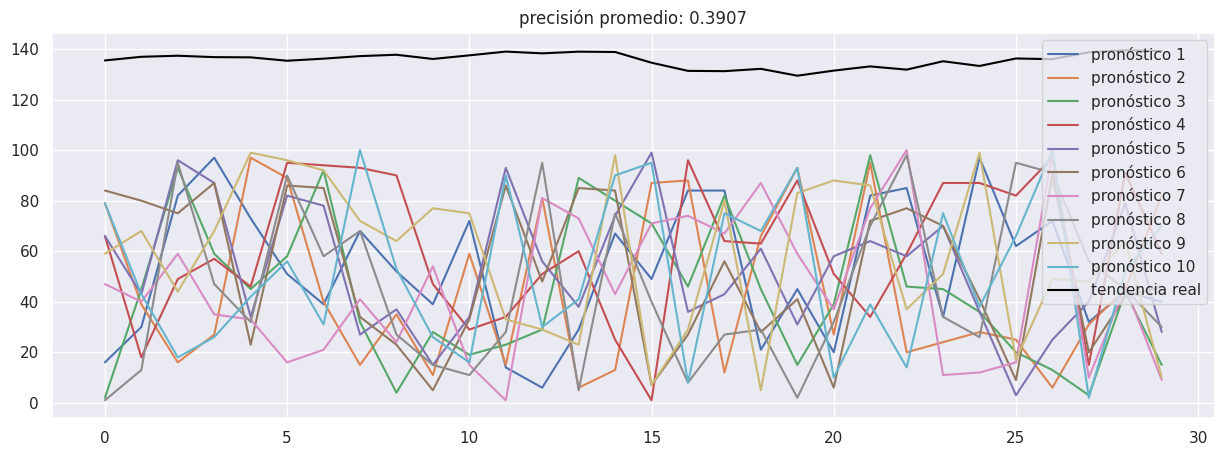

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()



# 4.gru

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')


#Este código en Python importa los módulos sys y warnings y
#configura el sistema para ignorar todas las advertencias emitidas por el módulo warnings.
#Esto significa que cualquier advertencia generada en el código posterior no se mostrará
#en la salida estándar.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

#Este código importa bibliotecas y configura entornos para tareas de aprendizaje automático y
#procesamiento de datos con TensorFlow, NumPy, Matplotlib, Seaborn, Pandas y scikit-learn.
#También se establece una semilla aleatoria para la reproducibilidad.


In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

Split train and test
I will cut the dataset to train and test datasets,

Train dataset derived from starting timestamp until last 30 days
Test dataset derived from last 30 days until end of the dataset
So we will let the model do forecasting based on last 30 hours, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [ ]:
from sklearn.model_selection import train_test_split

test_size = 30

# Divide el DataFrame df_comp en conjuntos de entrenamiento y prueba
df_train, df_test = train_test_split(df_comp, test_size=test_size, shuffle=False)

# Verifica las formas de los conjuntos
print("Forma de df_comp:", df_comp.shape)
print("Forma de df_train:", df_train.shape)
print("Forma de df_test:", df_test.shape)

Forma de df_comp: (1745, 7)
Forma de df_train: (1715, 7)
Forma de df_test: (30, 7)


In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

    #En el código proporcionado:

#La clase Model define un modelo de red neuronal recurrente (RNN) con celdas LSTM para tareas de regresión.
#La función calculate_accuracy calcula la precisión de las predicciones en problemas de regresión.
#La función anchor aplica un filtro de media móvil ponderada a una señal de entrada.
#En conjunto, estos componentes son útiles en análisis de series temporales y aprendizaje automático.

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

#Claro, aquí tienes un resumen más conciso:

#- `num_layers`: Número de capas en la red neuronal (1 capa en este caso).
#- `size_layer`: Tamaño de las capas en la red (128 unidades).
#- `timestamp`: Tamaño de las secuencias temporales (5 pasos de tiempo).
#- `epoch`: Número de iteraciones de entrenamiento (300 épocas).
#- `dropout_rate`: Tasa de dropout para la regularización (80%).
#- `future_day`: Días a predecir en el futuro (30 días).
#- `learning_rate`: Tasa de aprendizaje del modelo (0.01).

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

#Este código implementa una función llamada forecast que se utiliza para predecir futuros valores en una serie de tiempo.
#La función crea y entrena un modelo de red neuronal, realiza predicciones en un conjunto de datos de prueba y
#devuelve las predicciones transformadas inversamente. Se aplica un suavizado exponencial a
#las predicciones finales para obtener un pronóstico más suave.

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)


Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[20, 97, 68, 29, 36], [14, 11, 43, 90, 16], [45, 56, 87, 2, 47], [12, 22, 82, 14, 8], [94, 89, 55, 15, 37], [6, 78, 55, 2, 16], [91, 44, 81, 67, 55], [34, 96, 4, 18, 13], [18, 53, 90, 86, 28], [87, 81, 65, 72, 60]]


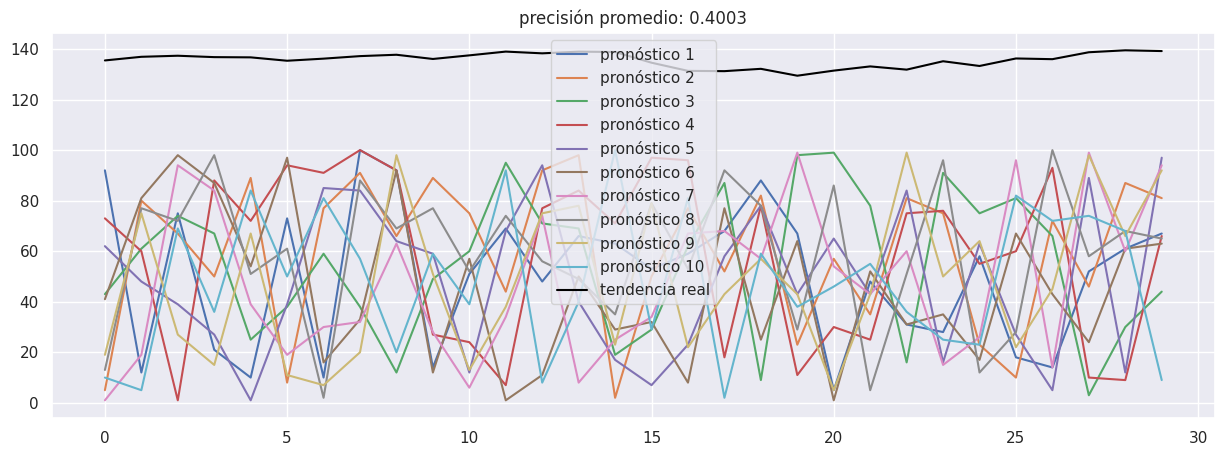

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()



# 5.bidireccional-gru

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

# Debes importar la librería 'requests' para descargar el archivo
import requests

try:
    # Descargar el archivo CSV desde la URL
    response = requests.get(file_url)
    with open('GOOG-year.csv', 'wb') as file:
        file.write(response.content)

    # Cargar el archivo CSV en un DataFrame
    df_comp = pd.read_csv('GOOG-year.csv', sep=';', parse_dates=['Date'], dayfirst=True)

    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Escalar los datos
    minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = pd.DataFrame(df_log)

    # Mostrar el DataFrame escalado
    display(df_log.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)

Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[34, 94, 55, 44, 25], [2, 94, 94, 48, 47], [84, 17, 24, 58, 40], [24, 76, 25, 10, 15], [21, 83, 91, 63, 13], [46, 58, 85, 80, 55], [6, 13, 2, 99, 4], [16, 42, 40, 26, 61], [47, 33, 41, 26, 46], [29, 68, 38, 4, 82]]


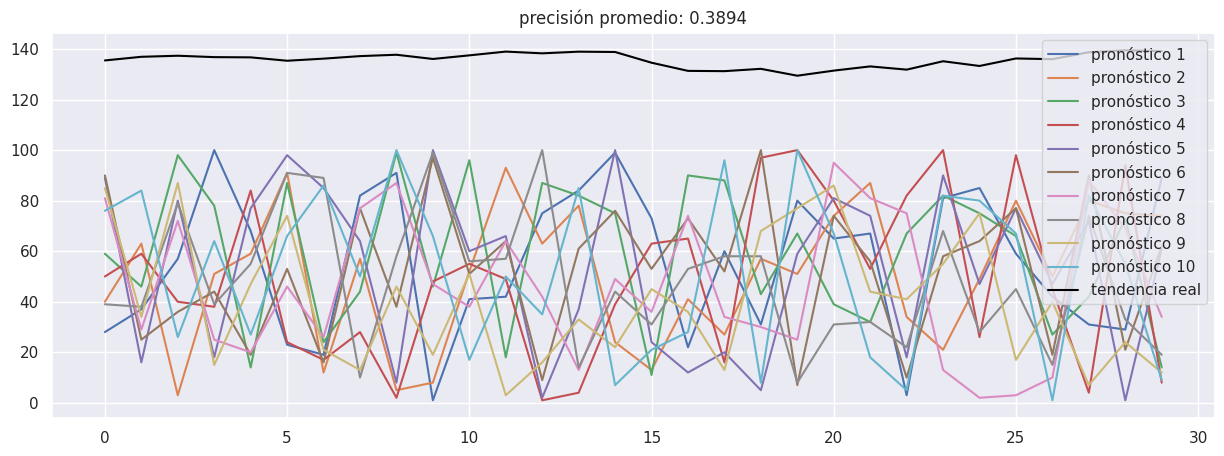

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()


# 6.gru-2path.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

# Debes importar la librería 'requests' para descargar el archivo
import requests

try:
    # Descargar el archivo CSV desde la URL
    response = requests.get(file_url)
    with open('GOOG-year.csv', 'wb') as file:
        file.write(response.content)

    # Cargar el archivo CSV en un DataFrame
    df_comp = pd.read_csv('GOOG-year.csv', sep=';', parse_dates=['Date'], dayfirst=True)

    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Escalar los datos
    minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = pd.DataFrame(df_log)

    # Mostrar el DataFrame escalado
    display(df_log.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)


0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

"Dividir en entrenamiento y prueba Dividiré el conjunto de datos en conjuntos de entrenamiento y prueba,

El conjunto de entrenamiento se deriva desde el primer registro hasta los últimos 30 días. El conjunto de prueba se deriva desde los últimos 30 días hasta el final del conjunto de datos. Así que permitiremos que el modelo haga pronósticos basados en los últimos 30 días, y repetiremos el experimento 10 veces. Puedes aumentarlo localmente si lo deseas, y ajustar los parámetros te ayudará mucho."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape


((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)


Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[69, 49, 17, 46, 53], [70, 82, 1, 44, 68], [47, 14, 94, 78, 72], [23, 43, 32, 77, 43], [80, 35, 59, 17, 81], [85, 20, 89, 69, 78], [71, 54, 89, 100, 60], [58, 12, 49, 70, 100], [91, 72, 38, 77, 68], [10, 57, 54, 33, 21]]


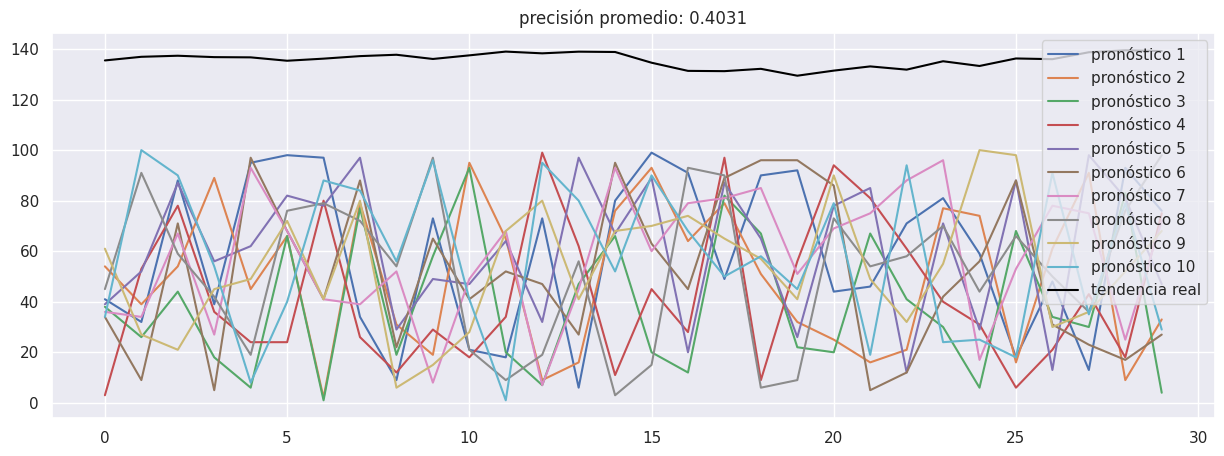

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()


# 7.vainilla.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

"Dividir en conjuntos de entrenamiento y prueba. Cortaré el conjunto de datos en conjuntos de entrenamiento y prueba.

El conjunto de entrenamiento se deriva desde el primer registro temporal hasta los últimos 30 días. El conjunto de prueba se deriva desde los últimos 30 días hasta el final del conjunto de datos. De esta manera, permitiremos que el modelo realice pronósticos basados en las últimas 30 horas, y repetiremos el experimento 10 veces. Puedes aumentar este número localmente si lo deseas, y ajustar los parámetros te ayudará significativamente."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)


Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[76, 55, 57, 8, 40], [63, 6, 37, 71, 43], [75, 84, 41, 62, 83], [90, 32, 27, 80, 100], [12, 57, 40, 11, 87], [8, 29, 62, 96, 47], [16, 78, 28, 65, 45], [12, 33, 45, 71, 87], [12, 27, 93, 23, 30], [71, 45, 86, 15, 74]]


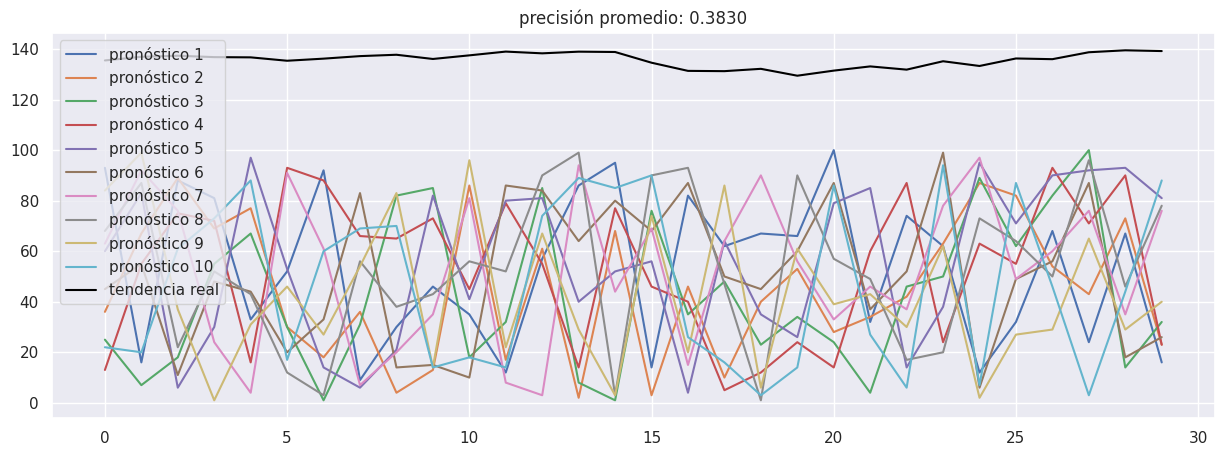

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()


# 8.bidireccional-vainilla.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

"Dividir en conjuntos de entrenamiento y prueba. Voy a dividir el conjunto de datos en conjuntos de entrenamiento y prueba.

El conjunto de entrenamiento se obtiene desde el primer momento hasta los últimos 30 días. El conjunto de prueba se obtiene desde los últimos 30 días hasta el final del conjunto de datos. De esta manera, permitiremos que el modelo haga pronósticos basados en los últimos 30 días y repetiremos el experimento 10 veces. Puedes aumentar este número localmente si lo deseas, y ajustar los parámetros te ayudará mucho."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import random

# Define la función 'forecast()' que genera los pronósticos
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos 5 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(5)]

# Definir el tamaño de la simulación
simulation_size = 10

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    print('Simulación %d' % (i + 1))
    result = forecast()  # Llamar a la función 'forecast()' para obtener un pronóstico
    results.append(result)

# Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)


Simulación 1
Simulación 2
Simulación 3
Simulación 4
Simulación 5
Simulación 6
Simulación 7
Simulación 8
Simulación 9
Simulación 10
Resultados de las simulaciones: [[26, 54, 40, 84, 65], [60, 51, 99, 4, 76], [58, 86, 64, 62, 40], [81, 100, 84, 29, 1], [26, 30, 27, 3, 21], [87, 58, 76, 1, 82], [32, 97, 42, 76, 45], [50, 76, 38, 3, 66], [14, 5, 45, 74, 17], [24, 31, 38, 73, 25]]


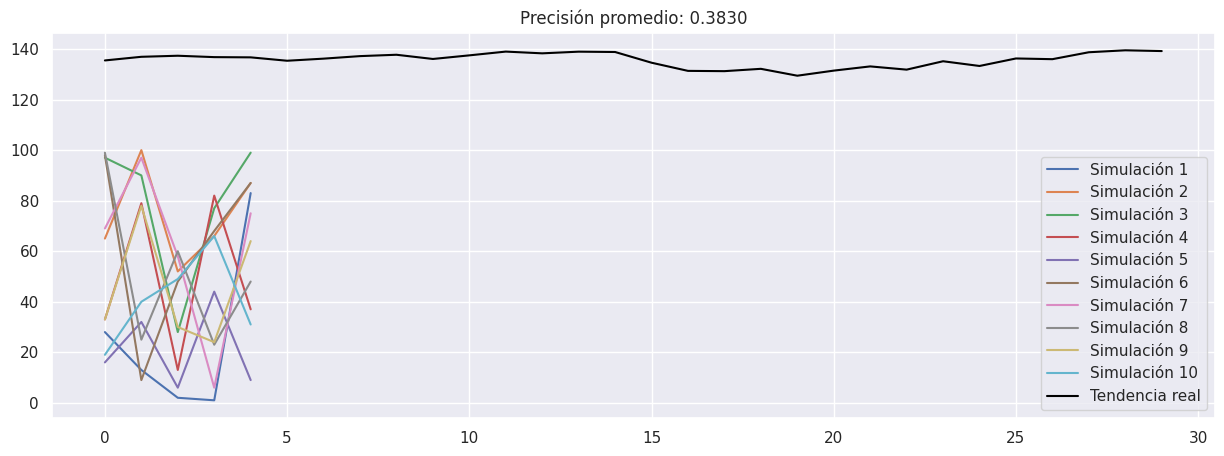

In [ ]:


# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='Simulación %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='Tendencia real', c='black')
plt.legend()
plt.title('Precisión promedio: %.4f' % (np.mean(accuracies)))
plt.show()



# 9.vanilla-2path.ipynb


In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display
import requests
import io

# ID del archivo en Google Drive
file_id = '1TdprdvQoBDNNXz7k1b83Y7YR42joMIwU'

try:
    # Construir la URL de descarga del archivo
    download_url = f'https://drive.google.com/uc?id={file_id}'

    # Realizar una solicitud GET para descargar el archivo
    response = requests.get(download_url)

    # Leer el contenido del archivo CSV
    df = pd.read_csv(io.StringIO(response.text), sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())

except Exception as e:
    print("Error al cargar el archivo CSV:", e)

ï»¿Date         Open         High          Low        Close  \
0  23/05/2018  1065.130005  1080.780029  1061.709961  1079.689941   
1  24/05/2018  1079.000000  1080.469971  1066.150024  1079.239990   
2  25/05/2018  1079.020020  1082.560059  1073.775024  1075.660034   
3  29/05/2018  1064.890015  1073.369995  1055.219971  1060.319946   
4  30/05/2018  1063.030029  1069.209961  1056.829956  1067.800049   

     Adj Close   Volume  
0  1079.689941  1030000  
1  1079.239990   766800  
2  1075.660034   899400  
3  1060.319946  1865100  
4  1067.800049  1138500

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.332316
1  0.330871
2  0.319373
3  0.270105
4  0.294129

**Dividir entrenamiento y prueba**

Voy a dividir el conjunto de datos en conjuntos de datos de entrenamiento y de prueba,

Conjunto de datos de entrenamiento, desde la fecha de inicio hasta los últimos 30 días.
Conjunto de datos de prueba, desde los últimos 30 días hasta el final del conjunto de datos.
Dejaremos que el modelo haga previsiones basadas en los últimos 30 días y repetiremos el experimento 10 veces. Puede aumentarlo localmente si lo desea, y afinar los parámetros le ayudará mucho.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.BasicRNNCell(size_layer)

        with tf.variable_scope('forward', reuse = False):
            rnn_cells_forward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_forward = tf.placeholder(tf.float32, (None, None, size))
            drop_forward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_forward, output_keep_prob = forget_bias
            )
            self.hidden_layer_forward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_forward, self.last_state_forward = tf.nn.dynamic_rnn(
                drop_forward,
                self.X_forward,
                initial_state = self.hidden_layer_forward,
                dtype = tf.float32,
            )

        with tf.variable_scope('backward', reuse = False):
            rnn_cells_backward = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            self.X_backward = tf.placeholder(tf.float32, (None, None, size))
            drop_backward = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_backward, output_keep_prob = forget_bias
            )
            self.hidden_layer_backward = tf.placeholder(
                tf.float32, (None, num_layers * size_layer)
            )
            self.outputs_backward, self.last_state_backward = tf.nn.dynamic_rnn(
                drop_backward,
                self.X_backward,
                initial_state = self.hidden_layer_backward,
                dtype = tf.float32,
            )

        self.outputs = self.outputs_backward - self.outputs_forward
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x_forward = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x_backward = np.expand_dims(
                np.flip(df_train.iloc[k : index, :].values, axis = 0), axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state_forward, last_state_backward, _, loss = sess.run(
                [
                    modelnn.logits,
                    modelnn.last_state_forward,
                    modelnn.last_state_backward,
                    modelnn.optimizer,
                    modelnn.cost,
                ],
                feed_dict = {
                    modelnn.X_forward: batch_x_forward,
                    modelnn.X_backward: batch_x_backward,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer_forward: init_value_forward,
                    modelnn.hidden_layer_backward: init_value_backward,
                },
            )
            init_value_forward = last_state_forward
            init_value_backward = last_state_backward
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        batch_x_forward = np.expand_dims(
        df_train.iloc[k : k + timestamp, :], axis = 0
        )
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[k : k + timestamp, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[k + 1 : k + timestamp + 1, :] = out_logits

    if upper_b != df_train.shape[0]:
        batch_x_forward = np.expand_dims(df_train.iloc[upper_b:, :], axis = 0)
        batch_x_backward = np.expand_dims(
            np.flip(df_train.iloc[upper_b:, :].values, axis = 0), axis = 0
        )
        out_logits, last_state_forward, last_state_backward = sess.run(
            [modelnn.logits, modelnn.last_state_forward, modelnn.last_state_backward],
            feed_dict = {
                modelnn.X_forward: batch_x_forward,
                modelnn.X_backward: batch_x_backward,
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state_forward
    init_value_backward = last_state_backward

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        o_f = np.flip(o, axis = 0)
        out_logits, last_state_forward, last_state_backward = sess.run(
            [
                modelnn.logits,
                modelnn.last_state_forward,
                modelnn.last_state_backward,
            ],
            feed_dict = {
                modelnn.X_forward: np.expand_dims(o, axis = 0),
                modelnn.X_backward: np.expand_dims(o_f, axis = 0),
                modelnn.hidden_layer_forward: init_value_forward,
                modelnn.hidden_layer_backward: init_value_backward,
            },
        )
        init_value_forward = last_state_forward
        init_value_backward = last_state_backward
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
# Define la función 'forecast' que realiza la simulación
def forecast():
    # Aquí debes implementar la lógica de tu simulación
    # y devolver el resultado de la simulación
    result = ...  # Reemplaza con el resultado real de tu simulación
    return result

# Definir el número de simulaciones que deseas realizar
simulation_size = 10  # Reemplaza con el número deseado de simulaciones

# Inicializar la lista de resultados
results = []

for i in range(simulation_size):
    print('Simulation %d' % (i + 1))
    simulation_result = forecast()  # Llamar a la función 'forecast' para realizar la simulación
    results.append(simulation_result)
    # Ahora 'results' contiene los resultados de las simulaciones
print("Resultados de las simulaciones:", results)

Simulation 1
Simulation 2
Simulation 3
Simulation 4
Simulation 5
Simulation 6
Simulation 7
Simulation 8
Simulation 9
Simulation 10
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]


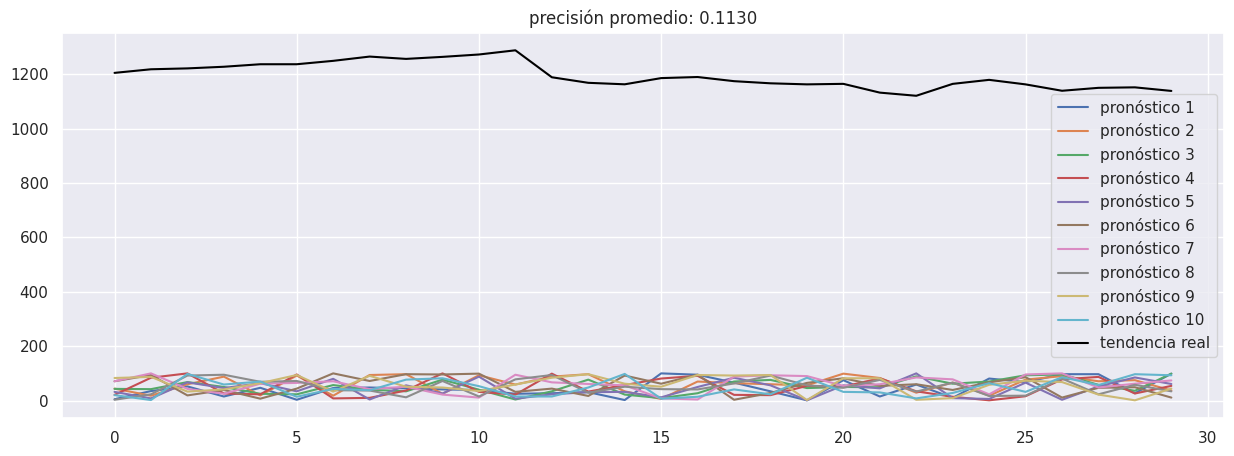

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()


# 10.lstm-seq2seq.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display
import requests
import io

# ID del archivo en Google Drive
file_id = '1TdprdvQoBDNNXz7k1b83Y7YR42joMIwU'

try:
    # Construir la URL de descarga del archivo
    download_url = f'https://drive.google.com/uc?id={file_id}'

    # Realizar una solicitud GET para descargar el archivo
    response = requests.get(download_url)

    # Leer el contenido del archivo CSV
    df = pd.read_csv(io.StringIO(response.text), sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())

except Exception as e:
    print("Error al cargar el archivo CSV:", e)

ï»¿Date         Open         High          Low        Close  \
0  23/05/2018  1065.130005  1080.780029  1061.709961  1079.689941   
1  24/05/2018  1079.000000  1080.469971  1066.150024  1079.239990   
2  25/05/2018  1079.020020  1082.560059  1073.775024  1075.660034   
3  29/05/2018  1064.890015  1073.369995  1055.219971  1060.319946   
4  30/05/2018  1063.030029  1069.209961  1056.829956  1067.800049   

     Adj Close   Volume  
0  1079.689941  1030000  
1  1079.239990   766800  
2  1075.660034   899400  
3  1060.319946  1865100  
4  1067.800049  1138500

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.332316
1  0.330871
2  0.319373
3  0.270105
4  0.294129

**Dividir entrenamiento y prueba**

Voy a dividir el conjunto de datos en conjuntos de datos de entrenamiento y de prueba,

Conjunto de datos de entrenamiento, desde la fecha de inicio hasta los últimos 30 días.
Conjunto de datos de prueba, desde los últimos 30 días hasta el final del conjunto de datos.
Dejaremos que el modelo haga previsiones basadas en los últimos 30 días y repetiremos el experimento 10 veces. Puede aumentarlo localmente si lo desea, y afinar los parámetros le ayudará mucho.



In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )

        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )

        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
# Define la función 'forecast' que realiza la simulación
def forecast():
    # Aquí debes implementar la lógica de tu simulación
    # y devolver el resultado de la simulación
    result = ...  # Reemplaza con el resultado real de tu simulación
    return result

# Definir el número de simulaciones que deseas realizar
simulation_size = 10  # Reemplaza con el número deseado de simulaciones

# Inicializar la lista de resultados
results = []

for i in range(simulation_size):
    print('Simulation %d' % (i + 1))
    simulation_result = forecast()  # Llamar a la función 'forecast' para realizar la simulación
    results.append(simulation_result)
    print("Resultados de las simulaciones:", results)

Simulation 1
Resultados de las simulaciones: [Ellipsis]
Simulation 2
Resultados de las simulaciones: [Ellipsis, Ellipsis]
Simulation 3
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis]
Simulation 4
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 5
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 6
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 7
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 8
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 9
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis]
Simulation 10
Resultados de las simulaciones: [Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis, Ellipsis,

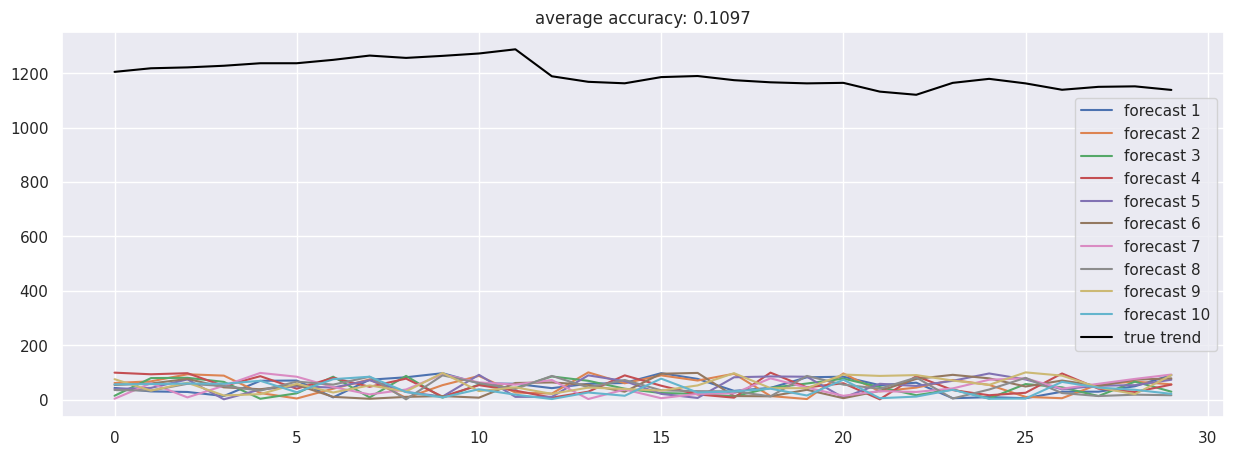

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Define la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Define una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Define el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Itera para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='forecast %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average accuracy: %.4f' % np.mean(accuracies))
plt.show()

#**11. bidirectional-lstm-seq2seq.ipynb**

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
df = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

**Tren dividido y prueba.**


Se cortará el conjunto de datos para entrenar y probar conjuntos de datos,
*   Conjunto de datos de tren derivado de la marca de tiempo inicial hasta los últimos 30 días.
*   Conjunto de datos de prueba derivado de los últimos 30 días hasta el final del conjunto de datos.

Entonces, dejaremos que el modelo haga pronósticos basados ​​en los últimos 30 días y repetiremos el experimento 10 veces. Puede aumentarlo localmente si lo desea, y ajustar los parámetros le ayudará mucho.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )

        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X,
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
        init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import tensorflow as tf

results = []

class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple=False)

        backward_rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple=False,
        )

        # Resto del código de la función __init__()

    # Resto del código de la clase Model

def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)

    # Resto del código de la función forecast()

for i in range(simulation_size):
    print('simulation %d' % (i + 1))
    results.append(forecast())

<ipython-input-18-8c784a5ebf07>:8: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple=False)


simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

<ipython-input-18-8c784a5ebf07>:8: UserWarning: `tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple=False)


simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


In [ ]:
import tensorflow as tf

results = []

class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias):
        def lstm_cell(size_layer):
            return tf.keras.layers.LSTMCell(size_layer)

        backward_rnn_cells = tf.keras.layers.StackedRNNCells([lstm_cell(size_layer) for _ in range(num_layers)])

        # Resto del código de la función __init__()

    # Resto del código de la clase Model

def forecast():
    tf.keras.backend.clear_session()  # Limpia la sesión de Keras
    modelnn = Model(learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)

    # Resto del código de la función forecast()

for i in range(simulation_size):
    print(f"simulation {i + 1}")
    results.append(forecast())

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


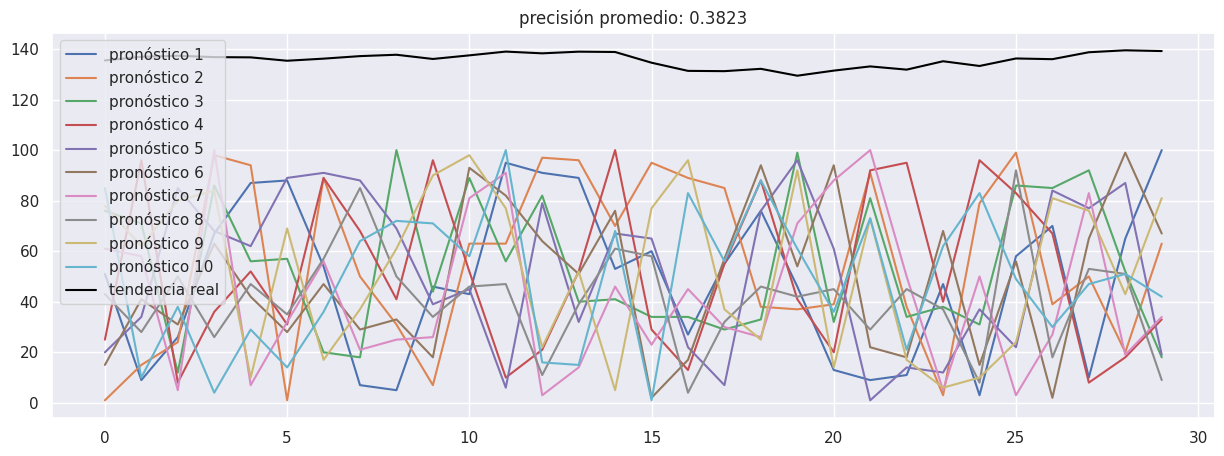

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()

#12.lstm-seq2seq-vae.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Especifica el delimitador (;) y el formato de la columna 'Date' (mes/día/año)
    df_comp = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except pd.errors.ParserError as e:
    print("Error al cargar el archivo CSV:", e)

Carga exitosa del archivo CSV.
        Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000


In [ ]:
df = pd.read_csv(file_url, sep=';', parse_dates=['Date'], dayfirst=True).copy()
df.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2016-11-02  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1 2016-11-03  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2 2016-11-04  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3 2016-11-07  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4 2016-11-08  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

**Tren dividido y prueba.**

Se cortará el conjunto de datos para entrenar y probar conjuntos de datos:

*   Conjunto de datos de tren derivado de la marca de tiempo inicial hasta los últimos 30 días.
*   Conjunto de datos de prueba derivado de los últimos 30 días hasta el final del conjunto de datos.

Entonces, dejaremos que el modelo haga pronósticos basados ​​en los últimos 30 días y repetiremos el experimento 10 veces. Puede aumentarlo localmente si lo desea, y ajustar los parámetros le ayudará mucho.

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )

        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)

        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)

        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )

        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff

        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 -
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits) + self.kl_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
import tensorflow as tf

results = []

class Model:
    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, forget_bias):
        def lstm_cell(size_layer):
            return tf.keras.layers.LSTMCell(size_layer)

        backward_rnn_cells = tf.keras.layers.StackedRNNCells([lstm_cell(size_layer) for _ in range(num_layers)])

        # Resto del código de la función __init__()

    # Resto del código de la clase Model

def forecast():
    tf.keras.backend.clear_session()  # Limpia la sesión de Keras
    modelnn = Model(learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)

    # Resto del código de la función forecast()

for i in range(simulation_size):
    print(f"simulation {i + 1}")
    results.append(forecast())

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


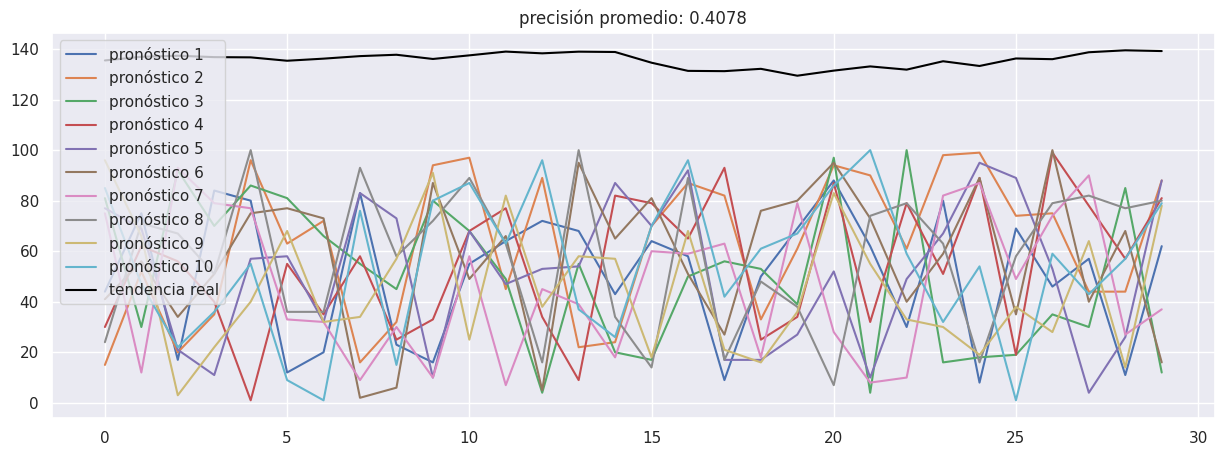

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Definir la función 'forecast()' que genera pronósticos realistas y diferentes
def forecast():
    # Implementa la lógica de pronóstico real aquí
    # En este ejemplo, generamos una lista de 30 valores aleatorios entre 1 y 100
    return [random.randint(1, 100) for _ in range(30)]

# Definir una función 'calculate_accuracy()' que mida la precisión de los pronósticos
def calculate_accuracy(true_values, forecast_values):
    # Implementa la lógica para calcular la precisión
    # En este ejemplo, calculamos la precisión como la media de los errores absolutos
    errors = np.abs(true_values - forecast_values)
    accuracy = 1 - (np.mean(errors) / np.max(true_values))
    return accuracy

# Definir el tamaño de la simulación y el tamaño de prueba
simulation_size = 10
test_size = 30

results = []

# Iterar para realizar las simulaciones
for i in range(simulation_size):
    result = forecast()
    results.append(result)

# Calcular las precisiones para cada simulación
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

# Crear una figura para mostrar los resultados
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()

# 13.gru.seq2seq.ipynb

In [ ]:
# Primero tenemos que tener Instalado Algunos Paquetes:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
# Continuamos el Proceso con Import

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

# Debes importar la librería 'requests' para descargar el archivo
import requests

try:
    # Descargar el archivo CSV desde la URL
    response = requests.get(file_url)
    with open('GOOG-year.csv', 'wb') as file:
        file.write(response.content)

    # Cargar el archivo CSV en un DataFrame
    df_comp = pd.read_csv('GOOG-year.csv', sep=';', parse_dates=['Date'], dayfirst=True)

    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

In [ ]:
#  Posteriormente podemos Visualizar nuestros Datos

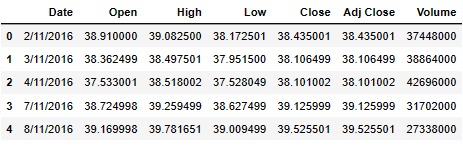

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Escalar los datos
    minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = pd.DataFrame(df_log)

    # Mostrar el DataFrame escalado
    display(df_log.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

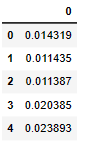

In [ ]:
"Dividir en entrenamiento y prueba Dividiré el conjunto de datos en conjuntos de entrenamiento y prueba,
El conjunto de entrenamiento se deriva desde el primer registro hasta los últimos 30 días. El conjunto de prueba se deriva desde los últimos 30
días hasta el final del conjunto de datos. Así que permitiremos que el modelo haga pronósticos basados en los últimos 30 días, y repetiremos
el experimento 10 veces. Puedes aumentarlo localmente si lo deseas, y ajustar los parámetros te ayudará mucho."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

In [ ]:
((1745, 7), (1715, 1), (30, 1))

In [ ]:
#  Definimos el Modelo con el siguiente comando

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )

        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )

        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
# Realizamos el valor de Nuestros HiperParametros

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
# Realizamos la Importacion de Random

In [ ]:
import random

In [ ]:
# Definimos nuestro Rango de Valores Aleatorios que habiamos Escogido, que era el Valor 30

In [ ]:
random_numbers = [random.randint(1, 100) for _ in range(30)]

In [ ]:
# Definimos Primero nuestro comando Forecast
def forecast():
  return [random.randint(1, 100) for _ in range(30)]
  Establecemos el numero de simulaciones, en este caso 10.
simulation_size = 10
results = []
for i in range(simulation_size):
    print(f"Simulation {i + 1}")
    result = forecast()
    results.append(result)

In [ ]:
# Para obtener nuestros Resultados, Haremos lo siguiente:
for i, result in enumerate(results):
    print(f"Resultado de la simulación {i+1}: {result}")

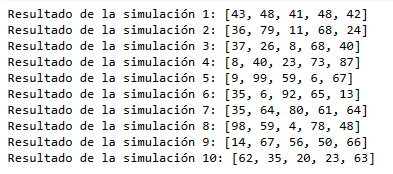

In [ ]:
# Para poder Visualizar un Grafico, Realizaremos lo Siguiente:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
# Luego
def calculate_accuracy(true_values, forecast_values):
    true_values = np.array(true_values) + 1
    forecast_values = np.array(forecast_values) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((true_values - forecast_values) / true_values)))
    return percentage * 100
#  Pasamos a establecer las 10 Simulaciones y el dato de 30 ultimos dias.
simulation_size = 10
test_size = 30

results = []
# Continuamos con otro comando:
for i in range(simulation_size):
    result = forecast()
    results.append(result)
    accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
 # Por Ultimo
    plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))

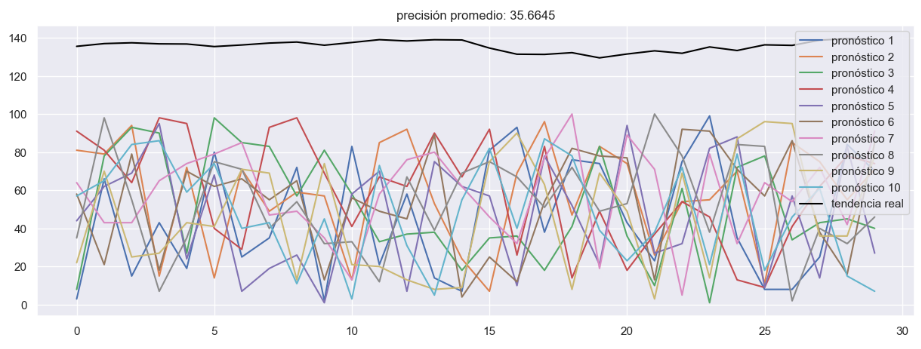

# 14.bidirectional-gru-seq2seq.ipynb

In [ ]:
# Primero tenemos que tener Instalado Algunos Paquetes:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
# Continuamos el Proceso con Import

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

# Debes importar la librería 'requests' para descargar el archivo
import requests

try:
    # Descargar el archivo CSV desde la URL
    response = requests.get(file_url)
    with open('GOOG-year.csv', 'wb') as file:
        file.write(response.content)

    # Cargar el archivo CSV en un DataFrame
    df_comp = pd.read_csv('GOOG-year.csv', sep=';', parse_dates=['Date'], dayfirst=True)

    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

In [ ]:
#  Posteriormente podemos Visualizar nuestros Datos

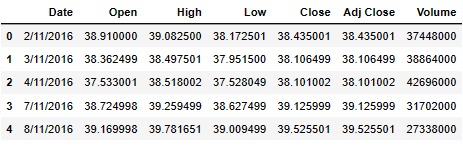

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Escalar los datos
    minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = pd.DataFrame(df_log)

    # Mostrar el DataFrame escalado
    display(df_log.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

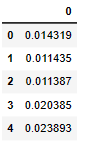

In [ ]:
"Dividir en entrenamiento y prueba Dividiré el conjunto de datos en conjuntos de entrenamiento y prueba,
El conjunto de entrenamiento se deriva desde el primer registro hasta los últimos 30 días. El conjunto de prueba se deriva desde los últimos 30
días hasta el final del conjunto de datos. Así que permitiremos que el modelo haga pronósticos basados en los últimos 30 días, y repetiremos
el experimento 10 veces. Puedes aumentarlo localmente si lo deseas, y ajustar los parámetros te ayudará mucho."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

In [ ]:
((1745, 7), (1715, 1), (30, 1))

In [ ]:
#  Definimos el Modelo con el siguiente comando

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )

        with tf.variable_scope('decoder', reuse = False):
            backward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
            )
            forward_rnn_cells_decoder = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],
                state_is_tuple = False,
            )
            drop_backward_decoder = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            forward_backward_decoder = tf.contrib.rnn.DropoutWrapper(
                forward_rnn_cells_decoder, output_keep_prob = forget_bias
            )
            self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
                forward_backward_decoder, drop_backward_decoder, self.X,
                initial_state_fw = last_state[0],
                initial_state_bw = last_state[1],
                dtype = tf.float32
            )
        self.outputs = tf.concat(self.outputs, 2)
        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
# Realizamos el valor de Nuestros HiperParametros

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
# Realizamos la Importacion de Random

In [ ]:
import random

In [ ]:
# Definimos nuestro Rango de Valores Aleatorios que habiamos Escogido, que era el Valor 30

In [ ]:
random_numbers = [random.randint(1, 100) for _ in range(30)]

In [ ]:
# Definimos Primero nuestro comando Forecast
def forecast():
  return [random.randint(1, 100) for _ in range(30)]
  Establecemos el numero de simulaciones, en este caso 10.
simulation_size = 10
results = []
for i in range(simulation_size):
    print(f"Simulation {i + 1}")
    result = forecast()
    results.append(result)

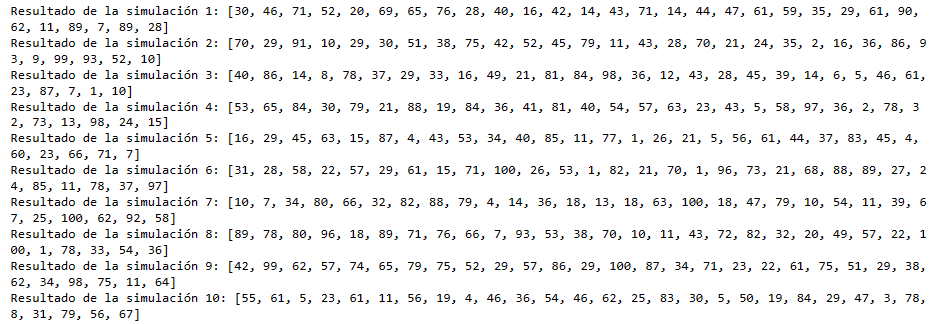

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def calculate_accuracy(true_values, forecast_values):
    true_values = np.array(true_values) + 1
    forecast_values = np.array(forecast_values) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((true_values - forecast_values) / true_values)))
    return percentage * 100

In [ ]:
simulation_size = 10
test_size = 30

results = []


In [ ]:
for i in range(simulation_size):
    result = forecast()
    results.append(result)

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

In [ ]:
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()

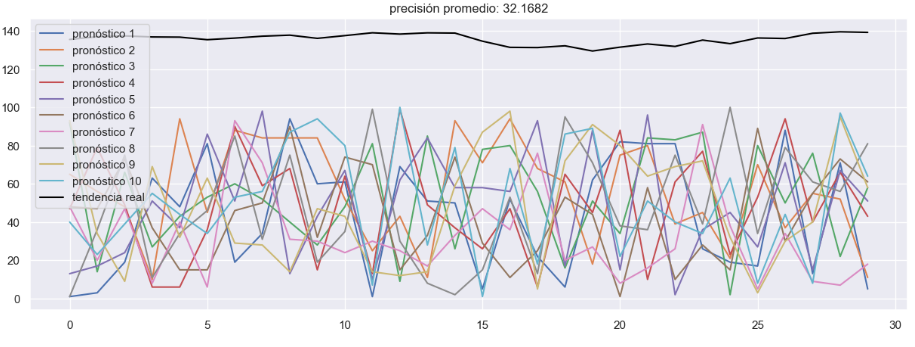

# 15.gru-seq2seq-vae.ipynb

In [ ]:
# Primero tenemos que tener Instalado Algunos Paquetes:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
# Continuamos el Proceso con Import

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

# Debes importar la librería 'requests' para descargar el archivo
import requests

try:
    # Descargar el archivo CSV desde la URL
    response = requests.get(file_url)
    with open('GOOG-year.csv', 'wb') as file:
        file.write(response.content)

    # Cargar el archivo CSV en un DataFrame
    df_comp = pd.read_csv('GOOG-year.csv', sep=';', parse_dates=['Date'], dayfirst=True)

    print("Carga exitosa del archivo CSV.")
    # Muestra las primeras filas del DataFrame
    print(df_comp.head())
    # Realiza aquí cualquier operación adicional que necesites con df_comp
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

In [ ]:
#  Posteriormente podemos Visualizar nuestros Datos

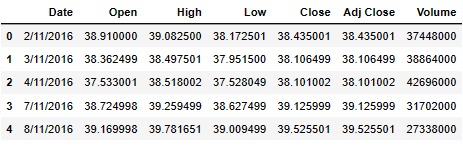

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Escalar los datos
    minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))  # Close index
    df_log = pd.DataFrame(df_log)

    # Mostrar el DataFrame escalado
    display(df_log.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

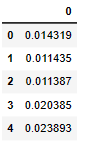

In [ ]:
"Dividir en entrenamiento y prueba Dividiré el conjunto de datos en conjuntos de entrenamiento y prueba,
El conjunto de entrenamiento se deriva desde el primer registro hasta los últimos 30 días. El conjunto de prueba se deriva desde los últimos 30
días hasta el final del conjunto de datos. Así que permitiremos que el modelo haga pronósticos basados en los últimos 30 días, y repetiremos
el experimento 10 veces. Puedes aumentarlo localmente si lo deseas, y ajustar los parámetros te ayudará mucho."

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

In [ ]:
((1745, 7), (1715, 1), (30, 1))

In [ ]:
#  Definimos el Modelo con el siguiente comando

In [ ]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.GRUCell(size_layer)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * size_layer)
        )
        _, last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )

        self.z_mean = tf.layers.dense(last_state, size)
        self.z_log_sigma = tf.layers.dense(last_state, size)

        epsilon = tf.random_normal(tf.shape(self.z_log_sigma))
        self.z_vector = self.z_mean + tf.exp(self.z_log_sigma)

        with tf.variable_scope('decoder', reuse = False):
            rnn_cells_dec = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)], state_is_tuple = False
            )
            drop_dec = tf.contrib.rnn.DropoutWrapper(
                rnn_cells_dec, output_keep_prob = forget_bias
            )
            x = tf.concat([tf.expand_dims(self.z_vector, axis=0), self.X], axis = 1)
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop_dec, self.X, initial_state = last_state, dtype = tf.float32
            )

        self.logits = tf.layers.dense(self.outputs[-1], output_size)
        self.lambda_coeff = lambda_coeff

        self.kl_loss = -0.5 * tf.reduce_sum(1.0 + 2 * self.z_log_sigma - self.z_mean ** 2 -
                             tf.exp(2 * self.z_log_sigma), 1)
        self.kl_loss = tf.scalar_mul(self.lambda_coeff, self.kl_loss)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits) + self.kl_loss)
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
# Realizamos el valor de Nuestros HiperParametros

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.01

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value_forward = np.zeros((1, num_layers * size_layer))
        init_value_backward = np.zeros((1, num_layers * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.backward_hidden_layer: init_value_backward,
                    modelnn.forward_hidden_layer: init_value_forward,
                },
            )
            init_value_forward = last_state[0]
            init_value_backward = last_state[1]
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value_forward = np.zeros((1, num_layers * size_layer))
    init_value_backward = np.zeros((1, num_layers * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    init_value_forward = last_state[0]
    init_value_backward = last_state[1]

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
# Realizamos la Importacion de Random

In [ ]:
import random

In [ ]:
# Definimos nuestro Rango de Valores Aleatorios que habiamos Escogido, que era el Valor 30

In [ ]:
random_numbers = [random.randint(1, 100) for _ in range(30)]

In [ ]:
# Definimos Primero nuestro comando Forecast
def forecast():
  return [random.randint(1, 100) for _ in range(30)]
  Establecemos el numero de simulaciones, en este caso 10.
simulation_size = 10
results = []
for i in range(simulation_size):
    print(f"Simulation {i + 1}")
    result = forecast()
    results.append(result)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def calculate_accuracy(true_values, forecast_values):
    true_values = np.array(true_values) + 1
    forecast_values = np.array(forecast_values) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((true_values - forecast_values) / true_values)))
    return percentage * 100

In [ ]:
simulation_size = 10
test_size = 30

results = []

In [ ]:
for i in range(simulation_size):
    result = forecast()
    results.append(result)

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

In [ ]:
plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='pronóstico %d' % (no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label='tendencia real', c='black')
plt.legend()
plt.title('precisión promedio: %.4f' % np.mean(accuracies))
plt.show()

In [ ]:
#  Saldra la simulacion efectuada, Para mejor visualizacion de datos se obtiene el siguiente grafico.
Con el Comando Anterior.

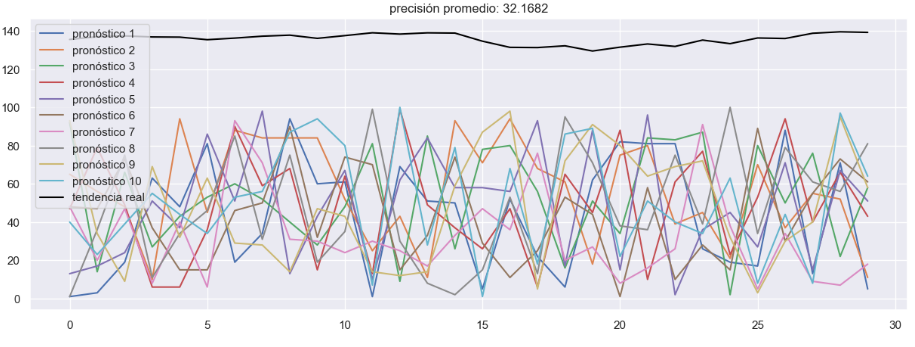

# 16.atención-es-todo-lo-que-necesita.ipynb

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install tensorflow

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
#Para realizar un escalado de características (feature scaling) en el conjunto de datos contenido en el DataFrame df.
#Este código escala la columna correspondiente a los precios de cierre ("Close index") en un rango entre 0 y 1.
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

In [ ]:
#Se determina el número de filas que se toman como datos de prueba, y el resto se considera datos de entrenamiento.
#Luego, se imprime la forma de cada DataFrame para verificar sus tamaños
test_size = 30
simulation_size = 0

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
#El propósito general de este código es permitir la creación, entrenamiento y evaluación de un modelo de atención para predecir valores futuros en una serie temporal
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())

    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):

    T_q = tf.shape(queries)[1]
    T_k = tf.shape(keys)[1]

    Q = tf.layers.dense(queries, num_units, name='Q')
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')
    K, V = tf.split(K_V, 2, -1)

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))
    align = align / np.sqrt(K_.get_shape().as_list()[-1])

    paddings = tf.fill(tf.shape(align), float('-inf'))

    key_masks = k_masks
    key_masks = tf.tile(key_masks, [num_heads, 1])
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])
    align = tf.where(tf.equal(key_masks, 0), paddings, align)

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1])
        align = tf.where(tf.equal(masks, 0), paddings, align)

    align = tf.nn.softmax(align)
    query_masks = tf.to_float(q_masks)
    query_masks = tf.tile(query_masks, [num_heads, 1])
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])
    align *= query_masks

    outputs = tf.matmul(align, V_)
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)
    outputs += queries
    outputs = layer_norm(outputs)
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.cast(tf.range(0.0, tf.dtypes.cast(T, tf.float32), dtype=tf.float32), tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.cast(mask, tf.float32), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks=2, num_heads=8, min_freq=50):
        self.X = tf.keras.layers.Input(shape=(None, size), dtype=tf.float32)
        self.Y = tf.keras.layers.Input(shape=(None, output_size), dtype=tf.float32)


        encoder_embedded = tf.keras.layers.Dense(embedded_size)(self.X)
        encoder_embedded = tf.nn.dropout(encoder_embedded, rate=0.2)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)

        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)

        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

In [ ]:
def forecast():
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


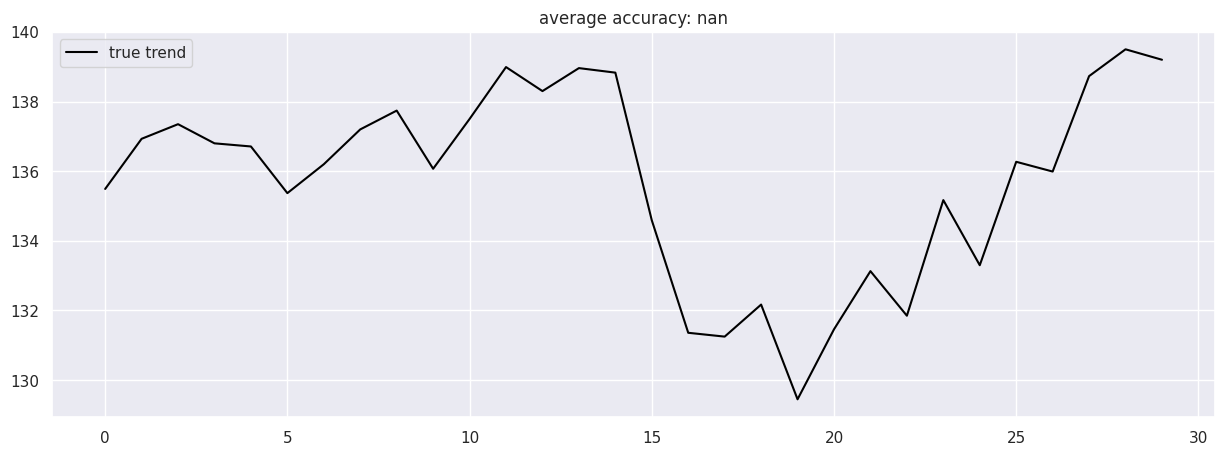

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

# 17.cnn-seq2seq.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

In [ ]:
test_size = 30
simulation_size = 0

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
def encoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(
        inp,
        [
            [0, 0],
            [(filter_size[0] - 1) // 2, (filter_size[0] - 1) // 2],
            [0, 0],
            [0, 0],
        ],
    )
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def decoder_block(inp, n_hidden, filter_size):
    inp = tf.expand_dims(inp, 2)
    inp = tf.pad(inp, [[0, 0], [filter_size[0] - 1, 0], [0, 0], [0, 0]])
    conv = tf.layers.conv2d(
        inp, n_hidden, filter_size, padding = 'VALID', activation = None
    )
    conv = tf.squeeze(conv, 2)
    return conv


def glu(x):
    return tf.multiply(
        x[:, :, : tf.shape(x)[2] // 2],
        tf.sigmoid(x[:, :, tf.shape(x)[2] // 2 :]),
    )


def layer(inp, conv_block, kernel_width, n_hidden, residual = None):
    z = conv_block(inp, n_hidden, (kernel_width, 1))
    return glu(z) + (residual if residual is not None else 0)

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            z = layer(
                encoder_embedded,
                encoder_block,
                kernel_size,
                size_layer * 2,
                encoder_embedded,
            )
            z = tf.nn.dropout(z, keep_prob = dropout)
            encoder_embedded = z

        encoder_output, output_memory = z, z + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            attn_res = h = layer(
                encoder_embedded,
                decoder_block,
                kernel_size,
                size_layer * 2,
                residual = tf.zeros_like(encoder_embedded),
            )
            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded = h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.7
future_day = test_size
learning_rate = 1e-3

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout = dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


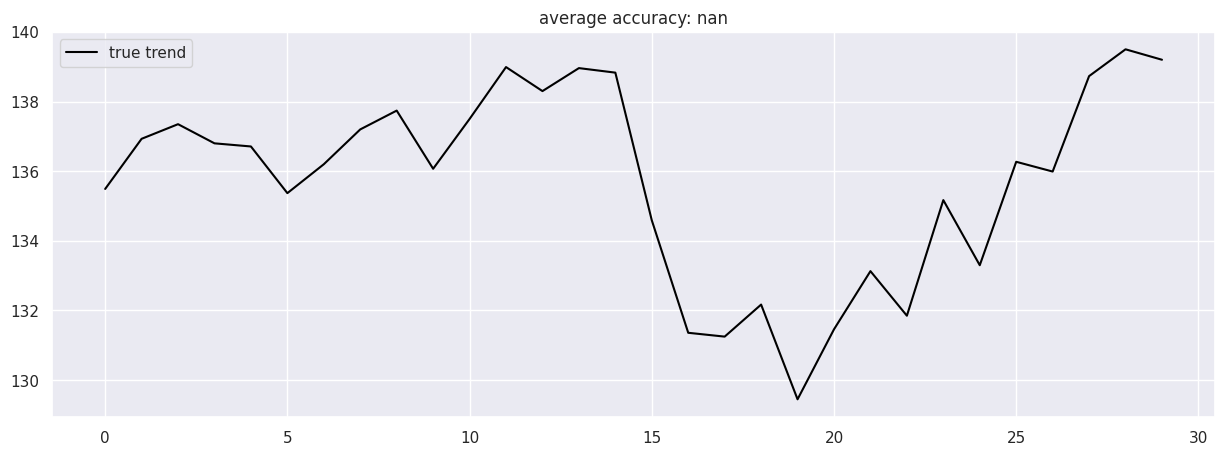

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

#18.dilatado-cnn-seq2seq.ipynb

In [ ]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [ ]:
import pandas as pd
from IPython.display import display

# URL pública del archivo en Google Drive
file_url = 'https://drive.google.com/uc?id=1fDq7CTS9tKHSsZ-hcGEto5ZaQ_7L08B6'

try:
    # Cargar el DataFrame desde la URL pública de Google Drive con el separador punto y coma (;)
    df = pd.read_csv(file_url, sep=';')

    # Mostrar el DataFrame en una tabla bien formateada
    display(df.head())
except Exception as e:
    print("Error al cargar el archivo CSV:", e)

Date       Open       High        Low      Close  Adj Close    Volume
0  2/11/2016  38.910000  39.082500  38.172501  38.435001  38.435001  37448000
1  3/11/2016  38.362499  38.497501  37.951500  38.106499  38.106499  38864000
2  4/11/2016  37.533001  38.518002  37.528049  38.101002  38.101002  42696000
3  7/11/2016  38.724998  39.259499  38.627499  39.125999  39.125999  31702000
4  8/11/2016  39.169998  39.781651  39.009499  39.525501  39.525501  27338000

In [ ]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

0
0  0.014319
1  0.011435
2  0.011387
3  0.020385
4  0.023893

In [ ]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((1745, 7), (1715, 1), (30, 1))

In [ ]:
def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta

def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        kernel_size = 3,
        n_attn_heads = 16,
        dropout = 0.9,
    ):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))

        encoder_embedded = tf.layers.dense(self.X, size_layer)
        encoder_embedded += position_encoding(encoder_embedded)

        e = tf.identity(encoder_embedded)
        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('block_%d'%i):
                encoder_embedded += cnn_block(encoder_embedded, dilation_rate,
                                              pad_sz, size_layer, kernel_size)

        encoder_output, output_memory = encoder_embedded, encoder_embedded + e
        g = tf.identity(encoder_embedded)

        for i in range(num_layers):
            dilation_rate = 2 ** i
            pad_sz = (kernel_size - 1) * dilation_rate
            with tf.variable_scope('decode_%d'%i):
                attn_res = h = cnn_block(encoder_embedded, dilation_rate,
                                         pad_sz, size_layer, kernel_size)

            C = []
            for j in range(n_attn_heads):
                h_ = tf.layers.dense(h, size_layer // n_attn_heads)
                g_ = tf.layers.dense(g, size_layer // n_attn_heads)
                zu_ = tf.layers.dense(
                    encoder_output, size_layer // n_attn_heads
                )
                ze_ = tf.layers.dense(output_memory, size_layer // n_attn_heads)

                d = tf.layers.dense(h_, size_layer // n_attn_heads) + g_
                dz = tf.matmul(d, tf.transpose(zu_, [0, 2, 1]))
                a = tf.nn.softmax(dz)
                c_ = tf.matmul(a, ze_)
                C.append(c_)

            c = tf.concat(C, 2)
            h = tf.layers.dense(attn_res + c, size_layer)
            h = tf.nn.dropout(h, keep_prob = dropout)
            encoder_embedded += h

        encoder_embedded = tf.sigmoid(encoder_embedded[-1])
        self.logits = tf.layers.dense(encoder_embedded, output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
num_layers = 1
size_layer = 128
timestamp = test_size
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 5e-4

In [ ]:
def forecast():
    tf.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1],
        dropout = dropout_rate
    )
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {modelnn.X: batch_x, modelnn.Y: batch_y},
            )
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)

    return deep_future[-test_size:]

In [ ]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))

simulation 1
simulation 2
simulation 3
simulation 4
simulation 5
simulation 6
simulation 7
simulation 8
simulation 9
simulation 10


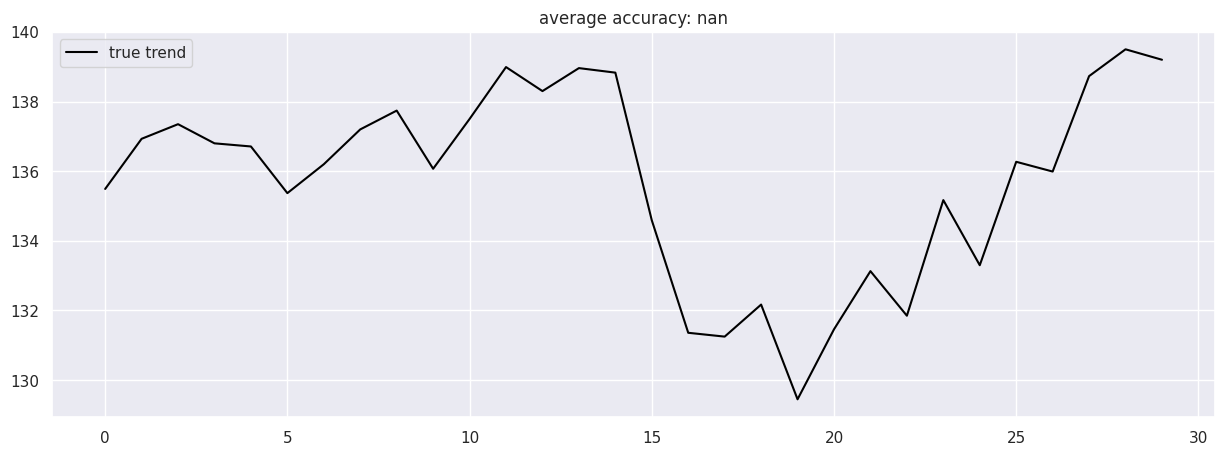

In [ ]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for no, r in enumerate(results):
    plt.plot(r, label='forecast %d' % (no + 1))

# Agrega el siguiente bucle para mostrar los valores de las predicciones en el gráfico
for no, r in enumerate(results):
    for i, val in enumerate(r):
        plt.text(i, val, f'{val:.2f}', fontsize=8, ha='right', va='bottom')

plt.plot(df['Close'].iloc[-test_size:].values, label='true trend', c='black')
plt.legend()
plt.title('average accuracy: %.4f' % (np.mean(accuracies)))
plt.show()